In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve 
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

# Antes se usaba otra función en la que venían los datos ordenados, pero la cambiarion y vienen sin orden
# Para solucionarlo definimos esta función

def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')


In [2]:
# mnist["data"] es un array de una fila por instancia y una columna por "feature"
# mnist["target"] es un array con los labels

X, y = mnist["data"], mnist["target"]

In [3]:
# Podemos comprobar la forma, 70.000 imágenes con 784 atributos, 28*28 pixeles que pueden ir de 0 (blanco)
# a 255 (negro)

X.shape

(70000, 784)

In [4]:
# y debe tener 70.000 labels, una por instancia o imagen

y.shape

(70000,)

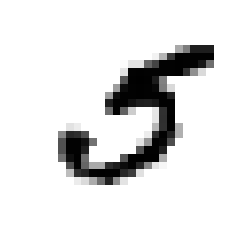

In [5]:
# Vamos a tomar una imagen cualquiera y mostrarla, por ejemplo la 36000. Tomamos su vector X, la escalamos a
# un array de 28*28, y hacemos el plot con imshow.

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [6]:
# Tiene pinta de ser un 5, y lo comprobamos viendo su label

y[36000]

5

In [7]:
# Antes de empezar a trabajar con el dataset debemos separar el training set del test set.
# MNIST ya viene preparado para ello, las primeras 60.000 imagenes para training y las 10.000 restantes test.

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
# Deberíamos también mezclar los datos para que los folds de cross-validation sean similares y no falten dígitos

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [9]:
# Clasificador Binario

# Vamos a simplificar primero el problema, entrenando un sistema que detecte si un dígito es un 5 o no lo es.
# Primero creamos los vectores objetivo para esta tarea de clasificación

y_train_5 = (y_train == 5) # Verdadero para los 5s, falso para todos los demás
y_test_5 = (y_test == 5)

In [10]:
# SGD Classifier
# Un buen lugar para empezar es un 'Stochastic Gradient Descent Classifier', usando las herramientas de 
# Scikit-Learn. Este clasificador es capaz de manejar muchos datos de forma eficaz. Lo entrenaremos con todo el
# training set, con 'random_state' fijo a 42 ya que si no sería aleatorio, así siempre nos sale lo mismo. Los
# parámetros max_iter y tol son relativamente nuevos, así que añadimos estos valores para que cuadren con el libro

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state = 42)
sgd_clf.fit(X_train, y_train_5)

# Predecimos la imagen que vimos antes

sgd_clf.predict([some_digit])

# Nos da true, con lo que la identifica como un 5. Parece que ha funcionado correctamente, así que evaluaremos 
# el rendimiento del modelo.

array([ True])

In [11]:
# Mediciones de Rendimiento

# Cross-Validation
# cross_val_score con 3 folds.

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

# Parece que sale un "accuracy" altísimo, pero esto se debe a que hay muchas imágenes que no son 5. Por ello
# la medida de "accuracy" no es la medida preferida para los clasificadores. Especialmente en los datasets
# 'skewed', es decir, cuando unas clases son mucho más frecuentes que otras

array([0.95895, 0.9697 , 0.9612 ])

In [12]:
# NOTA
# En ocasiones necesitamos más control que el que nos proporciona cross_val_score. Para ello podemos usar esto:
#
# from sklearn.model_selection import StratifiedKFold
# from sklearn.base import clone

# skfolds = StratifiedKFold(n_splits=3, random_state=42)

# for train_index, test_index in skfolds.split(X_train, y_train_5):
#     clone_clf = clone(sgd_clf)
#     X_train_folds = X_train[train_index]
#     y_train_folds = (y_train_5[train_index])
#     X_test_fold = X_train[test_index]
#     y_test_fold = (y_train_5[test_index])

#     clone_clf.fit(X_train_folds, y_train_folds)
#     y_pred = clone_clf.predict(X_test_fold)
#     n_correct = sum(y_pred == y_test_fold)
#     print(n_correct / len(y_pred)) # prints 0.9502, 0.96565 and 0.96495

In [13]:
# Matriz de Confusión

# Una forma mucho mejor de evaluar el comportamiento de un clasificador es mirar la matriz de confusión.
# La idea general es contar el número de veces que una instancia de clase A es clasificada como clase B.
# Por ejemplo, para saber el número de veces que el clasificador confundió imágenes de 5s con 3s, tienes que
# mirar en la quinta fila y tercera columna de la matriz de confusión.

# Para calcular la matriz de confusión, primero necesitamos un set de predicciones, para que puedan compararse
# con los objetivos. Se podrían hacer predicciones en el test set pero por ahora lo vamos a dejar sin tocar.
# En su lugar vamos a usar la función cross_val_predict()

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

# Es parecida a cross_val_score() pero en lugar de devolver los evaluation scores, devuelve las predicciones
# hechas en cada test fold
# Ahora ya se puede crear la matriz de confusión

confusion_matrix(y_train_5, y_train_pred)

# Cada fila de la matriz representa una 'actual class', mientras cada columna representa una 'predicted class'.
# La primera fila considera imágenes que no son 5 (clase negativa). 52422 (1-1) fueron clasificadas correctamente
# como no-5s (true negatives), mientras que 2157 (1-2) fueron erróneamente clasificados como 5s (false positives).
# La segunda fila considera imágenes que son 5s (la clase positiva). 1022 (2-1) fueron clasificadas erróneamente
# como no-5s (false negatives), mientras que los 4399 (2-2) restantes fueron clasificados correctamente como 5s
# (true positives). Un clasificador perfecto solo tendría true positives y true negatives, por lo que los valores
# fuera de la diagonal principal serán cero.

array([[53837,   742],
       [ 1461,  3960]])

In [14]:
# Aunque la matriz de confusión nos da información muy valiosa, a veces puede que queramos otras métricas. 
# Para ello tenemos 'precision' y 'recall', incluidas en Scikit-Learn.

print(precision_score(y_train_5, y_train_pred)) # TP/(TP+FP)

print(recall_score(y_train_5, y_train_pred)) # TP/(TP+FN)

# Esto significa que cuando el predictor dice que es un 5, sólo es correcto el 67% de las veces (recall),
# y que nuestro predictor detecta el 81% de los 5s (precision)

0.8421948107188431
0.7304925290536801


In [15]:
# Es recomendable también combinar precision y recall en una única métrica llamada F1 score. Es una media
# armónica de precision y recall, lo que significa que da mucho peso a valores bajos. Por lo tanto sólo se
# obtendrá un valor alto de F1 score si recall y precision son altos.

# F1 = 2 / ((1/Prec) + (1/Rec))

f1_score(y_train_5, y_train_pred)

# Esta métrica favorece a clasificadores que tengan similar precision y recall, pero a veces eso no es lo que
# queremos. Por ejemplo, si estamos entrenando un clasificador para decidir si ciertos vídeos son aptos para
# niños, preferiremos que se descarten videos adecuados (bajo recall) pero los que se quede sean adecuados
# (alta precisión), antes que tener un recall alto pero que se dejen pasar algunos videos no muy aptos. En estos
# casos incluso se puede querer tener un pipeline humano para supervisar.
# Por otro lado, si tenemos un clasificador para detectar ladrones en cámaras de seguridad, nos parecerá bien si
# tenemos un 30% de precisión pero un 99% de recall (se tendrán algunas falsas alertas pero casi todos los 
# ladrones se pillarán)
# Por desgracia no se pueden tener ambas, mejorar la precisión reduce el recall y viceversa, esto se llama 
# Precision/Recall Tradeof

0.782376765780895

In [16]:
# Precision/Recall Tradeof
# SGDClassifier hace las predicciones asignando un score a cada instancia y comparándolo con un umbral decide
# si es verdadero o falso. Scikit-Learn no nos deja fijar directamente el umbral, pero nos da acceso a los
# decision scores que usa para hacer predicciones. decision_function() devuelve un score para cada instancia.
# Luego podemos fijar un umbral y hacer predicciones en base a ello.

y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[88985.42560951]
[ True]


In [17]:
# SGDClassifier usa un umbral 0, por lo que el código anterior devuelve lo mismo que predict()
# Subamos el umbral

threshold = 200000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

# Subir el umbral baja el recall, la imagen es un 5 pero el clasificador falla si subimos el umbral a 200000.

[False]


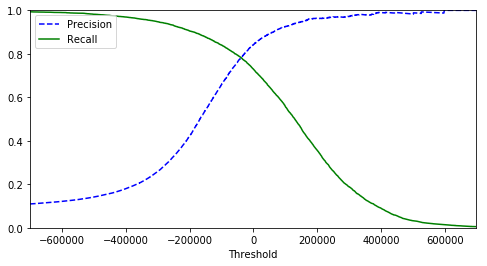

In [18]:
# ¿Entonces cómo podemos decidir el umbral que utilizar?
# Primero debo sacar todos los scores de las instancias del training set

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")

# Con estos scores podemos computar precision y recall para todos los posibles umbrales

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# Finalmente representamos precision y recall en función del umbral

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
    plt.xlabel("Threshold")
    plt.legend(loc = "upper left")
    plt.ylim([0, 1])

    
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

# De aquí podríamos seleccionar el umbral que nos interese según porcentajes de Precision y Recall

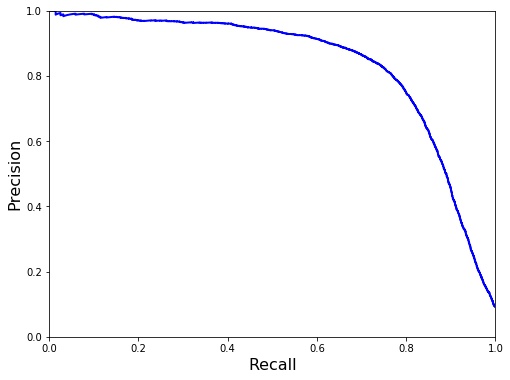

In [19]:
# Otra ayuda puede ser representar precision vs recall (PR)

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

# Vemos una caida abrupta en torno al 80% de recall.
# Un buen clasificador tendrá esta curva lo más pegado posible arriba a la derecha.

In [20]:
# Supongamos que decidimos un 90% de precision. Haciendo zoom en el primer plot veriamos que le corresponde un
# umbral de aproximadamente 200000 (varía segun intentos). Hagamos predicciones de otra forma, sin usar predict().

y_train_pred_90 = (y_scores > 200000)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.96318407960199
0.3571296808706881


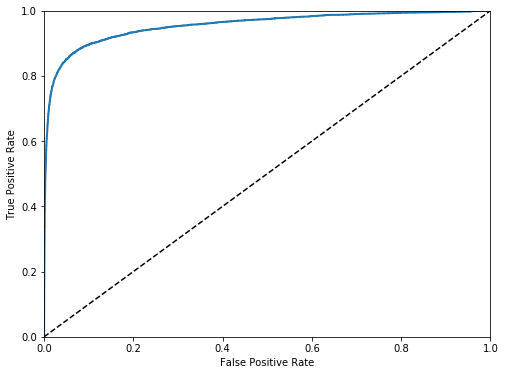

In [21]:
# Curva ROC - Receiver Operating Characteristic

# Parecida a la curva precision/recall, pero hace plot del true positive rate (recall) vs false positive rate.
# FPR: Ratio de negativos que son incorrectamente clasificados como positivos. (1 - True negative rate)
# TNR: Ratio de negativos correctamente clasificados como negativos (specificity)
# Entonces ROC representa sensitivity (recall) vs (1 - specificity)

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

# plot FPR vs TPR

def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

# Volvemos a tener tradeoff: a mayor recall (TPR), más falsos positivos (FPR) se producen. La linea de puntos
# representa la curva ROC de un clasificador puramente aleatorio. Un buen clasificador se aleja tanto como sea
# posible de esa línea, arriba a la izquierda.

In [22]:
# Una forma de comparar clasificadores es medir el área bajo la curva (AUC). Un clasificador perfecto tendrá 
# ROC AUC igual a 1. Un clasificador puramente aleatorio tendrá un ROC AUC igual a 0.5

roc_auc_score(y_train_5, y_scores)

# Como la curva ROC es parecida a la Precision/Recall (PR), para decidir cual usar podemos aplicar lo siguiente:
# Preferimos PR si la positive class es rara o si te preocupan más los falsos positivos que los falsos negativos,
# y la curva ROC a la inversa.
# Por ejemplo, mirando la curva ROC anterior, y el score ROC AUC, podríamos pensar que el clasificador es 
# realmente bueno, pero esto es porque hay pocos positivos (5s) comparado con los negativos (no-5s). En cambio, 
# la curva PR deja claro que el clasificador tiene posibilidades de mejora, la curva debería estar más pegada
# arriba a la derecha.

0.9549506178093267

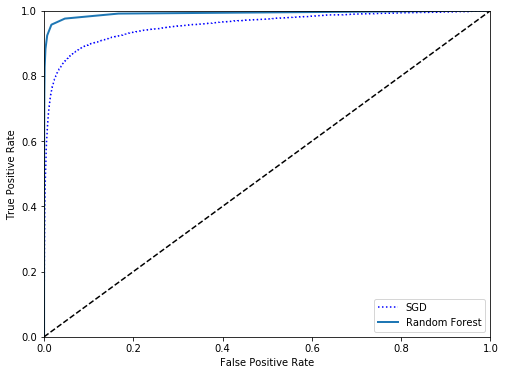

0.9916215875757591

In [23]:
# Entrenemos un Random Forest Classifier y comparemos su curva ROC y el ROC AUC score con el SGDClassifier

forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method="predict_proba")

# Esto nos da probabilidades, pero necesitamos scores para la ROC.

y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

# Ahora sí estamos listos para plotear la curva ROC. Haremos el plot de la primera ROC también para compararlas

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc = "lower right")
plt.show()

# Podemos ver que el Random Forest tiene una curva ROC con mucho mejor pinta que la del SGD, se va mucho más
# arriba a la izquierda. En consecuencia, ROC AUC debe ser significativamente mejor.

roc_auc_score(y_train_5, y_scores_forest)

In [24]:
# Mostramos precision score y recall score, 98.2% y 82.7%, no parece mal resultado.

y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
print(precision_score(y_train_5, y_train_pred_forest))

print(recall_score(y_train_5, y_train_pred_forest))

0.984409310496267
0.8269691938756687


In [25]:
# Clasificador Multiclase

# Se puede usar directamente un clasificador multiclase (Random Forest, Naive Bayes, ...), o varios binarios
# (Support Vector Machine, Linear, ...). Por ejemplo si quieres distinguir dígitor del 0 al 9 puedes entrenar 
# 9 clasificadores binarios, uno para distinguir cada uno, y seleccionar el que tenga el mayor score. Esto se 
# conoce como estrategia OvA (One versus All).
# Otra estrategia es entrenar un clasificador binario para cada par de números: 0-1, 0-2, 1-2, ... Esto se llama
# OvO (One versus One). Para N clases necesitaría N*(N-1)/2 clasificadores. Para nuestro caso significaría
# entrenar 45 clasificadores, y cada vez que quisiera clasificar una imagen tendría que pasarla por todos los
# clasificadores y elegir el que gane el mayor número de duelos. Lo bueno es que se entrenan con un training
# set menor, sólo con las dos partes del duelo.
# Algunos algoritmos como los Support Vector Machine escalan muy mal con el tamaño del training set, así que 
# en esos casos OvO funciona mejor porque entrenar más clasificadores con un training set más pequeño es más
# rápido. Para la mayoría de algoritmos binarios sin embargo OvA es mejor.

# Scikit-Learn detecta automáticamente si estoy tratando de usar un clasificador binario para multiclass, y si es
# así lanza OvA automáticamente, excepto en el caso de SVM que lanza OvO.

# Probemos con el SGDClassifier

sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

# Este código está entrenando el SGDClassifier en el trainig set de 0 a 9, después hace una predicción correcta.
# Se han entrenado 10 clasificadores binarios, recogido sus scores y seleccionado aquel mayor, todo sin enterarnos

array([5], dtype=int8)

In [26]:
# Vamos a ver esto, tendremos un vector de 10 scores, uno por clase

some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)

# Chequeamos cual es el mayor

print(np.argmax(some_digit_scores))
print(sgd_clf.classes_)
print(sgd_clf.classes_[5])

[[ -65322.85557794 -628693.81700181 -464691.63914215 -369961.92741903
  -338013.14648236   88985.42560951 -707680.4855376  -410552.24350702
  -540384.09177753 -530577.004247  ]]
5
[0 1 2 3 4 5 6 7 8 9]
5


In [27]:
# Podemos forzar a Scikit-Learn a usar OvO o OvA. Por ejemplo, a continuación un OvO SGDClassifier

from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state = 42))
ovo_clf.fit(X_train, y_train)
print(ovo_clf.predict([some_digit]))
print(len(ovo_clf.estimators_))

[5]
45


In [28]:
# Entrenar un Random Forest también es muy sencillo

forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=int8)

In [29]:
# Esta vez Scikit-Learn no ha tenido que lanzar OvA u OvO porque los clasificadores Random Forest son capaces
# de clasificar instancias en diferentes clases. Podemos ver la lista de probabilidades que el clasificador
# asigna a cada clase

forest_clf.predict_proba([some_digit])

array([[0.2, 0. , 0. , 0.2, 0. , 0.6, 0. , 0. , 0. , 0. ]])

In [30]:
# Vamos a evaluar los clasificadores, usaremos cross-validation como habitualmente.
# Evaluamos el SGDClassifier

print(cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy"))

# Obtenemos un 85% aprox en los tres folds. No está mal teniendo en cuenta que un clasificador aleatorio habría
# tenido alrededor de un 10%, pero aún se puede mejorar. Por ejemplo, simplemente escalando las entradas se
# aumenta la precisión por encima del 90%

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
print(cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy"))

[0.81778644 0.83694185 0.87188078]
[0.91171766 0.90929546 0.90728609]


In [31]:
# Análisis de errores

# Miremos la matriz de confusión.

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5739,    2,   23,    8,   12,   47,   41,    8,   38,    5],
       [   1, 6471,   53,   27,    6,   36,    9,   11,  117,   11],
       [  59,   38, 5352,   90,   87,   23,   92,   54,  145,   18],
       [  53,   37,  136, 5346,    3,  224,   39,   53,  141,   99],
       [  21,   30,   36,   11, 5370,    9,   56,   32,   72,  205],
       [  79,   45,   36,  187,   70, 4583,  109,   27,  183,  102],
       [  36,   22,   53,    2,   42,   92, 5624,    5,   42,    0],
       [  22,   16,   72,   28,   51,   11,    8, 5769,   16,  272],
       [  52,  154,   76,  154,   13,  159,   58,   25, 5019,  141],
       [  39,   33,   29,   90,  162,   34,    3,  186,   80, 5293]])

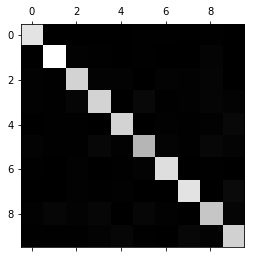

In [32]:
# A veces conviene mirar la representación en imagen de la matriz de confusión, puede ayudar

plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

In [33]:
# Esta matriz tiene un muy buen aspecto, porque la mayoría de imágenes están en la diagonal principal, lo
# cual implica que han sido clasificadas correctamente. La zona del 5 parece ligeramente más oscura que el resto,
# lo que puede significar que había menos imágenes de 5s en el dataset o que el clasificador no funciona tan bien
# con 5s como con otros dígitos. De hecho se puede comprobar que ambas son ciertas.

# Enfoquemos el plot a los errores. 
# Primero vamos a dividir cada valor de la matriz entre el número de imágenes en la clase correspondiente, para
# sacar ratios de error para cada clase en lugar de número absoluto de errores

row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

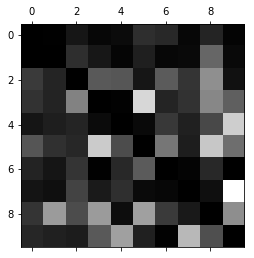

In [34]:
# Llenemos ahora la diagonal con ceros para quedarnos sólo con los errores, y mostremos el resultado

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

# Recordemos que las filas son las clases reales, mientras las columnas son las predicciones.
# Las columnas del 8 y 9 son bastante claras, lo cual implica que muchas imágenes son clasificadas erróneamente
# como 8s y 9s. De manera similar, las filas del 8 y 9 son bastante claras, lo que implica que los 8s y 9s se
# confunden bastante con otros números.

# Por contra, otras filas son bastante oscuras, como la del 1. Significa que los 1s se clasifican bien, quitando
# algunos que se confunden con 8s

# Observando la matriz se pueden encontrar formas de mejora. Por ejemplo en este caso convendría centrarse en
# detectar mejor 8s y 9s, así como en corregir las confusiones entre 3s y 5s. Se podría tratar de conseguir más
# ejemplos de estos casos para el dataset, o mejorar el clasificador, por ejemplo escribiendo un algoritmo que
# detecte el número de loops en la imagen (8: 2 loops, 6: 1 loop, 5: 0 loops). También se podría preprocesar las
# imágenes para hacer destacar más algunos patrones

In [35]:
import matplotlib as mpl

# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

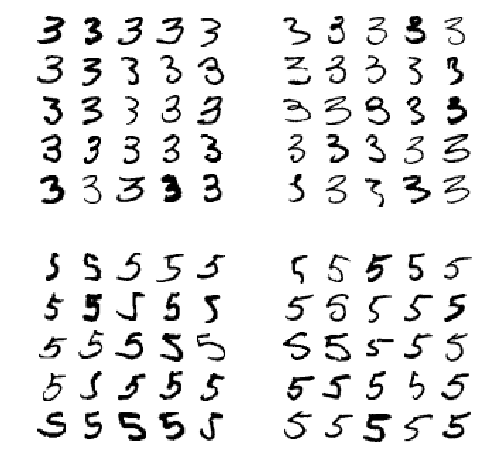

In [36]:
# Analizar los errores individuales también puede ser una buena forma de sacar insights de lo que hace nuestro
# clasificador y por qué falla, pero es más dificil y quita tiempo. Por ejemplo, mostremos ejemplos de 3s y 5s

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [37]:
# Los dos bloques de 5x5 de la izquierda son dígitos clasificador como 3s. Algunos de los dígitos mal clasificados
# por ejemplo los de abajo a la izquierda o arriba a la derecha, están tan mal escritos que hasta algunas personas
# podrían tener problemas clasificándolos.
# Aún así, la mayoría de fallos nos parecen imágenes con errores obvios, y cuesta entender cómo el clasificador
# puede fallar en ellas.
# La razón es que utilizamos un SGD simple, que es un modelo lineal. Lo que hace es asignar un peso por clase a 
# cada pixel y computa la suma de las intensidades de píxeles para sacar un score para cada clase. Como los 3s y
# los 5s difieren en unos pocos píxeles, este modelo los confunde fácilmente.

# La principal diferencia entre 3s y 5s es la posición de la línea vertical que une la parte superior e inferior.
# Si dibujas un 3 con la línea un poco a la izquierda, el clasificador podría identificarlo como un 5 y viceversa.
# En otras palabras, el clasificador es bastante sensible a la posición y rotación de las imágenes, así que una 
# forma de reducir la confusión es preprocesar cada imagen para asegurar que esté centrada y no muy rotada.

In [38]:
# Clasificación Multilabel

# Este tipo de clasificación es útil para encontrar varios objetos en la misma imagen.

from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

# Este código crea un array y_multilabel, conteniendo dos labels objetivo para cada imagen. El primero indica
# si el dígito es 7 o más, y el segundo indica si es impar o no. Después se crea un KNeighborsClassifier y lo
# entrenamos usando el array de target múltiple.

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [39]:
# Ahora se pueden hacer predicciones y ver que salen dos labels.

knn_clf.predict([some_digit])

# Y acierta! El 5 no es mayor que 7 (False), y es impar (True)

array([[False,  True]])

In [ ]:
# Hay muchas maneras de evaluar un multilabel, y seleccionar la métrica correcta depende del proyecto. 
# Una forma sería medir F1 score para cada label individual, o cualquier otra métrica de binario de las previas, 
# y después símplemente hacer el score medio.

# Ojo, esta celda va a tardar, puede que incluso horas

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3, n_jobs = -1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")